In [7]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops.init_ops import glorot_normal_initializer

In [8]:
mnist = input_data.read_data_sets("./data/", one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [9]:
def batch_norm_layer(inputs, is_training=None, name=None, decay=0.999, epsilon=1e-5):
    """
    Batch-Normalization Layer
    
    params
    ======
    - inputs: input Tensor
    - name(Optional): name of the layer
    - decay(Optional): decay rate of moving average of input moments
    - epsilon(Optional): epsilon to advoid dividing by 0.
    
    returns
    =======
    - is_training: a placeholder of type tf.bool. If the value is `True`, the
    layer will run in training phase, otherwise running in inference phase.
    - outputs: batch normalized outputs
    """
    if is_training is None:
        is_training = tf.placeholder(tf.bool, name="is_training")
    
    N_features = inputs.get_shape()[-1]
    scale = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="scale")
    offset = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="offset")
    
    moving_mean = tf.Variable(tf.zeros(N_features), 
                              trainable=False,
                              name="moving_mean")
    moving_vars = tf.Variable(tf.ones(N_features),
                              trainable=False,
                              name="moving_vars")
    
    def fn_inference(): 
        return tf.nn.batch_normalization(inputs,
                                         moving_mean,
                                         moving_vars,
                                         offset,
                                         scale,
                                         epsilon)
    
    # Follow the recommanded implementation in this issue 
    # https://github.com/tensorflow/tensorflow/issues/3287
    def fn_training():
        inputs_mean, inputs_vars = tf.nn.moments(inputs, [0])
        update_mean_op = tf.assign(moving_mean, decay*moving_mean+(1-decay)*inputs_mean)
        update_vars_op = tf.assign(moving_vars, decay*moving_vars+(1-decay)*inputs_vars)
        with tf.control_dependencies([update_mean_op, update_vars_op]):
            train_outputs = tf.nn.batch_normalization(inputs, 
                                                      inputs_mean, 
                                                      inputs_vars,
                                                      offset,
                                                      scale,
                                                      epsilon)
        return train_outputs 
    
    outputs = tf.cond(is_training, 
                      true_fn=fn_training, 
                      false_fn=fn_inference, 
                      name=name)
    return outputs, is_training

In [10]:
np.random.seed(1111)
w1_init = np.random.normal(size=(784, 100)).astype(np.float32)
w2_init = np.random.normal(size=(100, 100)).astype(np.float32)
w3_init = np.random.normal(size=(100, 10)).astype(np.float32)

In [11]:
graph_bn = tf.Graph()
with graph_bn.as_default():
    is_training = tf.placeholder(tf.bool)
    x_ = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # layer 1
    W1 = tf.Variable(w1_init, dtype=tf.float32)
    z1 = tf.matmul(x_, W1)
    a1, _ = batch_norm_layer(z1, is_training)
    l1 = tf.nn.sigmoid(a1)
    
    # layer 2
    W2 = tf.Variable(w2_init, dtype=tf.float32)
    z2 = tf.matmul(l1, W2)
    a2, _ = batch_norm_layer(z2, is_training)
    l2 = tf.nn.sigmoid(a2)
    
    # layer 3
    W3 = tf.Variable(w3_init, dtype=tf.float32)
    z3 = tf.matmul(l2, W3)
    y = tf.nn.softmax(z3)
    predict = tf.argmax(y, 1)
    
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy)

In [12]:
def comput_accuracy(y1, y2):
    return (y1 == y2).mean()

In [13]:
n_iterations = 40000
batch_size = 50

losses_bn = [None for _ in range(n_iterations)]
accuracy_bn = []

with tf.Session(graph=graph_bn) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels,
                      is_training:True}
        _, l = sess.run([train_op, cross_entropy], feed_dict=feed_dict)
        losses_bn[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = mnist.test.images
            feed_dict[y_] = mnist.test.labels
            feed_dict[is_training] = False
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = comput_accuracy(pred, np.argmax(mnist.test.labels, 1))
            accuracy_bn.append(acc)
            print("Iteration {}: loss {:.4f}, test acuuracy {:.2f}%".format(step+1, l, acc*100))

Iteration 1000: loss 26.6447, test acuuracy 56.75%
Iteration 2000: loss 4.4600, test acuuracy 83.59%
Iteration 3000: loss 49.0188, test acuuracy 90.79%
Iteration 4000: loss 8.7985, test acuuracy 91.46%
Iteration 5000: loss 5.3445, test acuuracy 92.58%
Iteration 6000: loss 14.9997, test acuuracy 93.18%
Iteration 7000: loss 11.6627, test acuuracy 93.47%
Iteration 8000: loss 6.1515, test acuuracy 94.39%
Iteration 9000: loss 8.7266, test acuuracy 94.53%
Iteration 10000: loss 4.8877, test acuuracy 94.92%
Iteration 11000: loss 13.8057, test acuuracy 94.90%
Iteration 12000: loss 18.0191, test acuuracy 95.33%
Iteration 13000: loss 18.6524, test acuuracy 95.46%
Iteration 14000: loss 4.1653, test acuuracy 95.75%
Iteration 15000: loss 9.9342, test acuuracy 95.91%
Iteration 16000: loss 4.4011, test acuuracy 95.85%
Iteration 17000: loss 8.8409, test acuuracy 95.84%
Iteration 18000: loss 1.8412, test acuuracy 95.92%
Iteration 19000: loss 3.9005, test acuuracy 96.10%
Iteration 20000: loss 13.6803, te

In [21]:
# network without batch normalization
graph_no_bn = tf.Graph()

with graph_no_bn.as_default():
    x_ = tf.placeholder(dtype=tf.float32, 
                        shape=[None, 784])
    y_ = tf.placeholder(dtype=tf.float32, 
                        shape=[None, 10])
    
    # fully connected layer 1
    W1_no_bn = tf.Variable(w1_init,
                           dtype=tf.float32)
    b1_no_bn = tf.Variable(np.zeros(w1_init.shape[-1]),
                           dtype=tf.float32)
    z1_no_bn = tf.matmul(x_, W1_no_bn)+b1_no_bn
    l1_no_bn = tf.nn.sigmoid(z1_no_bn)
    
    # fully connected layer 2
    W2_no_bn = tf.Variable(w2_init, 
                           dtype=tf.float32)
    b2_no_bn = tf.Variable(np.zeros(w2_init.shape[-1]),
                           dtype=tf.float32)
    z2_no_bn = tf.matmul(l1_no_bn, W2_no_bn)+b2_no_bn
    l2_no_bn = tf.nn.sigmoid(z2_no_bn)
    
    # fully connect layer 3
    W3_no_bn = tf.Variable(w3_init,
                           dtype=tf.float32)
    b3_no_bn = tf.Variable(np.zeros(w3_init.shape[-1]),
                           dtype=tf.float32)
    l3_no_bn = tf.matmul(l2_no_bn, W3_no_bn)+b3_no_bn
    
    y_hat_no_bn = tf.nn.softmax(l3_no_bn)
    predict = tf.argmax(l3_no_bn, 1)
    
    loss = -tf.reduce_sum(y_*tf.log(y_hat_no_bn))
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

In [22]:
n_iterations = 40000
batch_size = 50

losses = [None for _ in range(n_iterations)]
accuracy = []

with tf.Session(graph=graph_no_bn) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels}
        _, l = sess.run([train_op, loss], feed_dict=feed_dict)
        losses[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = mnist.test.images
            feed_dict[y_] = mnist.test.labels
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = comput_accuracy(pred, np.argmax(mnist.test.labels, 1))
            accuracy.append(acc)
            print("Iteration {}: loss {:.4f}, test acuuracy {:.2f}%".format(step+1, l, acc*100))

Iteration 1000: loss 31.2202, test acuuracy 86.40%
Iteration 2000: loss 9.9323, test acuuracy 89.18%
Iteration 3000: loss 14.9617, test acuuracy 90.91%
Iteration 4000: loss 3.5479, test acuuracy 91.83%
Iteration 5000: loss 22.7265, test acuuracy 92.30%
Iteration 6000: loss 1.7068, test acuuracy 93.08%
Iteration 7000: loss 18.0834, test acuuracy 93.11%
Iteration 8000: loss 3.1750, test acuuracy 93.54%
Iteration 9000: loss 7.9203, test acuuracy 93.74%
Iteration 10000: loss 7.8232, test acuuracy 93.75%
Iteration 11000: loss 3.7045, test acuuracy 94.05%
Iteration 12000: loss 4.9649, test acuuracy 94.25%
Iteration 13000: loss 11.1450, test acuuracy 94.26%
Iteration 14000: loss 3.1446, test acuuracy 94.31%
Iteration 15000: loss 2.3116, test acuuracy 94.28%
Iteration 16000: loss 3.1850, test acuuracy 94.51%
Iteration 17000: loss 13.6347, test acuuracy 94.50%
Iteration 18000: loss 2.7835, test acuuracy 94.40%
Iteration 19000: loss 1.4563, test acuuracy 94.68%
Iteration 20000: loss 2.2625, test

In [23]:
len(losses_bn)

40000

In [29]:
len(accuracy)

40

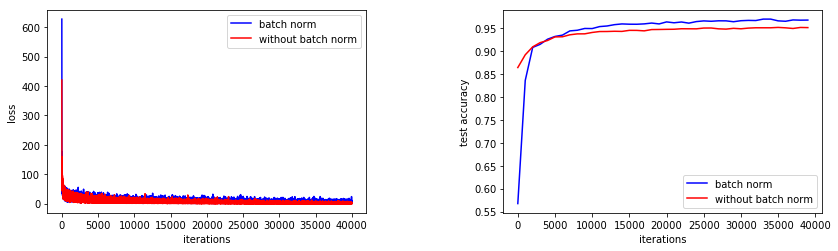

In [28]:
plt.subplot(1, 2, 1)
plt.plot(losses_bn, 'b-', label="batch norm")
plt.plot(losses, "r-", label="without batch norm")
plt.ylabel("loss")
plt.xlabel("iterations")
plt.legend()

plt.subplot(1, 2, 2)
x_range = np.arange(0, 40000, 1000)
plt.plot(x_range, accuracy_bn, '-b', label="batch norm")
plt.plot(x_range, accuracy, "-r", label="without batch norm")
plt.ylabel("test accuracy")
plt.xlabel("iterations")
plt.legend()

plt.tight_layout()
fig = plt.gcf().set_size_inches((13, 3.5))